In [92]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [93]:
# import and analyse dataset
labels = pd.read_csv('labels_and_ids.csv')
labels.groupby('jericho_human_classification').size()

jericho_human_classification
ham      590
phish     22
spam     539
dtype: int64

In [94]:
# narrow down to ham and spam
labels_without_phish = labels[labels['jericho_human_classification'] != 'phish']
# flatten inbound_event_ids
labels_without_phish.loc[:, 'inbound_event_ids'] = labels_without_phish['inbound_event_ids'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(','))
labels_without_phish = labels_without_phish.explode('inbound_event_ids')
# remove duplicates
labels_without_phish = labels_without_phish.drop_duplicates(subset='inbound_event_ids')
# convert inbound_event_ids to int
labels_without_phish.loc[:, 'inbound_event_ids'] = labels_without_phish['inbound_event_ids'].astype(int)
# save to ids to text
for i in labels_without_phish['inbound_event_ids']:
    with open('ids.txt', 'a') as f:
        f.write(f'{i},')


In [95]:
obj_df = pd.read_csv('obj_data.csv')
# merge with labels
obj_df = obj_df.merge(labels_without_phish, left_on='id', right_on='inbound_event_ids')
obj_df = obj_df.drop(columns=['id_x', 'id_y'])
obj_df['processed_body'] = obj_df['processed_body'].astype(str)
obj_df['processed_subject'] = obj_df['processed_subject'].astype(str)
obj_df['jericho_human_classification'] = obj_df['jericho_human_classification'].astype(str)
obj_df['inbound_event_ids'] = obj_df['inbound_event_ids'].astype(int)
obj_df.head()

,category,from,processed_body,processed_subject,jericho_human_classification,inbound_event_ids
0,bcc_email_sec_inbound,support@fsdgov.com,This email was sent by Automated Administrator...,SAM Notification | DSBS | FEMA Requirements fo...,spam,127
1,bcc_email_sec_inbound,naren@startupwindinc.com,"Webinar of Professor Wolcott, about Promixity ...",Webinar: Introducing “PROXIMITY” Your Guide t...,spam,128
2,bcc_email_sec_inbound,kade.beem@peopledatalabs.com,Downtime 5/20/24 between 6:15am and 8:00am PDT...,Upcoming Downtime ⚠️,ham,156
3,bcc_email_sec_inbound,notifications@github.com,Merged #649 into develop.,Re: [JerichoSecurity/jericho-security] Feature...,ham,159
4,bcc_email_sec_inbound,notifications@github.com,Merged #649 into develop.,Re: [JerichoSecurity/jericho-security] Feature...,ham,160


EDA of length of processed_body and processed_subject on classfications

Text(0, 0.5, 'Processed Subject Length')

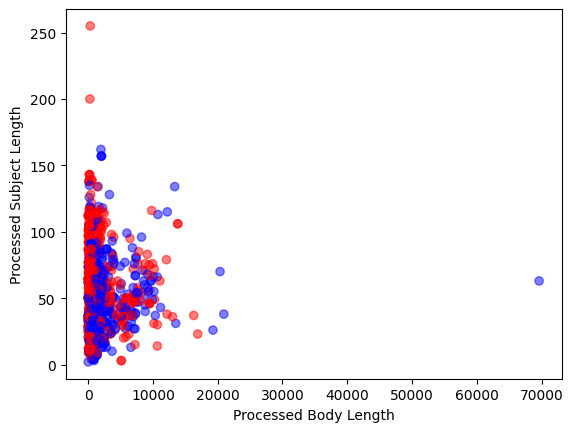

In [96]:
processed_body_len = obj_df['processed_body'].apply(lambda x: len(x))
processed_subject_len = obj_df['processed_subject'].apply(lambda x: len(x))
data_labels = obj_df['jericho_human_classification'].apply(lambda x: 1 if x == 'ham' else 0)
len_dataset = pd.DataFrame({'processed_body_length': processed_body_len, 'processed_subject_length': processed_subject_len, 'label': data_labels})
len_dataset.to_csv('len_dataset.csv', index=False)
plot = plt.scatter(processed_body_len, processed_subject_len, c=data_labels, cmap='bwr', alpha=0.5)
plt.xlabel('Processed Body Length')
plt.ylabel('Processed Subject Length')


In [97]:
# creating train and test set
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score
X = len_dataset[['processed_body_length', 'processed_subject_length']]
y = len_dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

np.float64(0.6153846153846154)

EDA of word length of processed_body and processed_subject on classfications

Text(0, 0.5, 'Processed Subject Words')

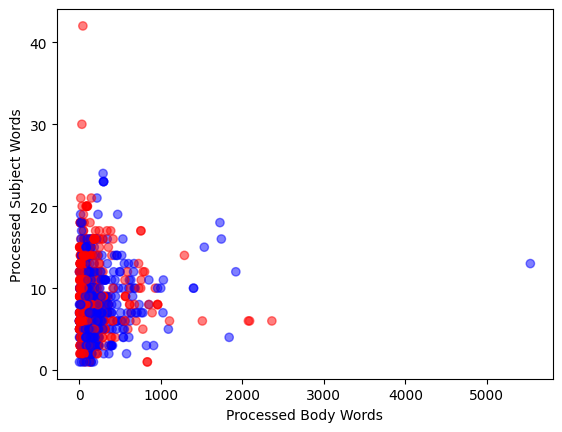

In [98]:
processed_body_words = obj_df['processed_body'].apply(lambda x: len(x.split()))
procssed_subject_words = obj_df['processed_subject'].apply(lambda x: len(x.split()))
words_dataset = pd.DataFrame({'processed_body_words': processed_body_words, 'processed_subject_words': procssed_subject_words, 'label': data_labels})
words_dataset.to_csv('words_dataset.csv', index=False)
plot = plt.scatter(processed_body_words, procssed_subject_words, c=data_labels, cmap='bwr', alpha=0.5)
plt.xlabel('Processed Body Words')
plt.ylabel('Processed Subject Words')

In [99]:
X= words_dataset[['processed_body_words', 'processed_subject_words']]
y = len_dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

np.float64(0.6536618006527468)

EDA with Naive Bayes model

In [100]:
# simplify body and subject
def simplify_text(text):
    text = text.lower()
    # remove links
    text = text.replace('http://', '').replace('https://', '')
    # remove non-text characters
    text = ''.join([i for i in text if i.isalpha() or i.isspace()])
    return text

simplified_body = obj_df['processed_body'].apply(simplify_text)
simplified_subject = obj_df['processed_subject'].apply(simplify_text)
simplified_data = pd.DataFrame({'simplified_body': simplified_body, 'simplified_subject': simplified_subject, 'label': data_labels})

In [ ]:
from wordcloud import WordCloud as wc
cloud = wc(width=800, height=400, background_color='white').generate(' '.join(simplified_body))
plt.imshow(cloud)
plt.axis('off')

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(simplified_body)
y = simplified_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
y_pred = gnb.predict(X_test.toarray())
f1_score(y_test, y_pred, average='weighted')
false_positive_rate = 1 - (y_test == y_pred).sum() / len(y_test)
print(f'False Positive Rate: {false_positive_rate}')


False Positive Rate: 0.17692307692307696
